<a href="https://colab.research.google.com/github/DanYT2/machine_learning/blob/main/Multiclass_NLP_using_Bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets -q

In [3]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from datasets import load_dataset

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU

import matplotlib.pyplot as plt

In [4]:
from IPython.utils import text
data = load_dataset('masakhane/masakhanews', 'swa')

texts = data['train']['headline'] + data['test']['headline'] + data['validation']['headline']
labels = data['train']['label'] + data['test']['label'] + data['validation']['label']

print(len(texts))
print(len(labels))

print(texts[:5])

  0%|          | 0/3 [00:00<?, ?it/s]

2371
2371
['Tetesi za soka Ulaya Jumatatu 26.04.2021: Varane, Camara, Nagelsmann, Willock, Azpilicueta', 'Je chanjo ya corona ni salama?', 'Matokeo ya uchaguzi Marekani 2020: Donald Trump amfuta kazi Waziri wa Ulinzi Mark Esper', 'Je wajua mwanamke na mwanaume hawapaswi kufanya mazoezi pamoja?', 'Watoto waliolazimika kuwa kimya kuhusu baba zao wakutana na maaskofu jijini Paris']


In [5]:
training_portion = 0.8

train_size = int(len(texts) * training_portion)
train_size

1896

In [6]:
train_texts = texts[0:train_size]
train_labels = labels[0:train_size]

val_texts = texts[train_size:]
val_labels = labels[train_size:]

print(len(train_texts), len(val_texts))

1896 475


In [7]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [8]:
vocab_size = 10000

tokenizer = Tokenizer(num_words = vocab_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

In [9]:
max_len = 200
padding_type = 'post'
trunc_type = 'post'

In [10]:
train_seq = tokenizer.texts_to_sequences(train_texts)
train_seq = pad_sequences(train_seq, maxlen = max_len, padding = padding_type, truncating = trunc_type)

val_seq = tokenizer.texts_to_sequences(val_texts)
val_seq = pad_sequences(val_seq, maxlen = max_len, padding = padding_type, truncating = trunc_type)

print(train_seq.shape)
print(train_labels.shape)

print(val_seq.shape)
print(val_labels.shape)

(1896, 200)
(1896,)
(475, 200)
(475,)


In [11]:
print(set(train_labels))
print(len(set(train_labels)))

{0, 1, 2, 3, 4, 5, 6}
7


In [12]:
# Embedding - Bi-LSTM - Dense - Dense
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(7, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 714,759
Trainable params: 714,759
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [14]:
hist = model.fit(train_seq, train_labels, epochs = 20, validation_data = [val_seq, val_labels], verbose=2)

Epoch 1/20
60/60 - 29s - loss: 1.7496 - accuracy: 0.3154 - val_loss: 1.5031 - val_accuracy: 0.4000 - 29s/epoch - 476ms/step
Epoch 2/20
60/60 - 12s - loss: 1.9152 - accuracy: 0.4140 - val_loss: 1.7134 - val_accuracy: 0.4105 - 12s/epoch - 195ms/step
Epoch 3/20
60/60 - 7s - loss: 1.5087 - accuracy: 0.5211 - val_loss: 1.4899 - val_accuracy: 0.4589 - 7s/epoch - 123ms/step
Epoch 4/20
60/60 - 2s - loss: 1.2186 - accuracy: 0.5849 - val_loss: 1.2699 - val_accuracy: 0.5137 - 2s/epoch - 36ms/step
Epoch 5/20
60/60 - 1s - loss: 0.9314 - accuracy: 0.7031 - val_loss: 1.1975 - val_accuracy: 0.5684 - 1s/epoch - 18ms/step
Epoch 6/20
60/60 - 2s - loss: 0.6577 - accuracy: 0.7959 - val_loss: 1.1465 - val_accuracy: 0.5558 - 2s/epoch - 27ms/step
Epoch 7/20
60/60 - 2s - loss: 0.7066 - accuracy: 0.7853 - val_loss: 1.8114 - val_accuracy: 0.3853 - 2s/epoch - 30ms/step
Epoch 8/20
60/60 - 2s - loss: 0.7547 - accuracy: 0.7648 - val_loss: 1.1690 - val_accuracy: 0.5495 - 2s/epoch - 26ms/step
Epoch 9/20
60/60 - 1s - l

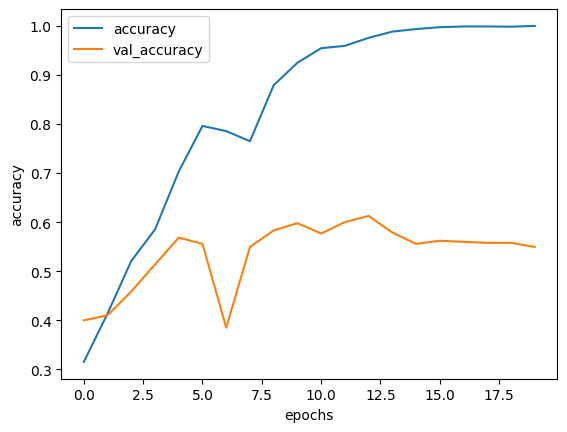

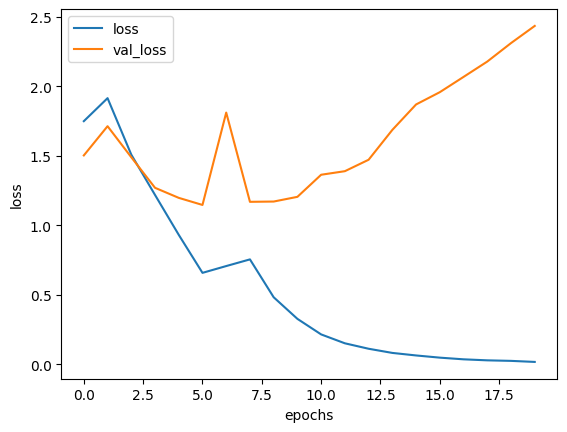

In [15]:
def plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot(hist, 'accuracy')
plot(hist, 'loss')

In [16]:
model.save('mclass.h5')

In [17]:
# save tokenizer
import pickle

with open('tok.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)